<a href="https://colab.research.google.com/github/wgova/time_series_trade/blob/master/notebooks/3a.%20pca_kmeans_tsfresh_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Required packages

In [170]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

try:
  !git clone https://github.com/wgova/automations
except:
  pass
else:
  os.chdir('automations')
  !git fetch origin && git pull
  os.chdir('../')

Mounted at /content/drive
fatal: destination path 'automations' already exists and is not an empty directory.
Already up to date.


In [171]:
# !pip install -q oec
# import oec
import re
import pandas as pd
import numpy as np
import json
from random import sample
import random
import itertools
import os, os.path, csv, requests, pathlib
from datetime import datetime
import math
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
%matplotlib inline
from math import sqrt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,\
StandardScaler\
,normalize
from sklearn import decomposition
from scipy.stats.mstats import winsorize
# from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering,DBSCAN
# from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from scipy.cluster.vq import kmeans,vq
from sklearn.metrics.cluster import homogeneity_score
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_samples,\
silhouette_score
from sklearn.decomposition import PCA

from automations.data_processors import *
from automations.correlation_analysis import *
from automations.feature_selection import *
from automations.clustering_helpers import *

## Data processing

In [172]:
# List of features
redundant_features = ['fft_coefficient','cwt_coefficients','count','change_quantiles','last_location_','agg_autocorrelation','index_mass_quantile',
                      'sum_values','sum_values','has_duplicate','length','quantile','ratio_beyond_r_sigma','ratio_value_number_to_time_series_length',
                      'agg','large_standard_deviation','number_crossing_m','number_cwt_peaks','reversal','value_count','spkt_welch_density','range_count','larger',
                      'variation_coefficient','max_langevin_fixed_point','reoccurring','symmetry_looking','variation','longest_strike_',
                      'variance_larger_than_standard_deviation']
min_feats = ['kurtosis','variance','mean','skewness','standard_deviation','median','sum_values','maximum','length','minimum']
stats = ['kurtosis','^mean$']
stationarity = ['autocorrelation','augmented']

## Load data

### Data preparation

In [173]:
experiment = "stationarity"
PATH = '/content/drive/My Drive/Stellenbosch/Webster'
import glob
files = {}
names = []
data = []
for filename in glob.glob(f"{PATH}/efficient_parameters/*.csv"):
  files[filename[66:-33]] = pd.read_csv(filename)
  for key in files.keys():
    name = key
    d_ = files.values()
  names.append(key)
  data.append(d_)

In [174]:
def load_features_data(ref: range,root_path: str,target_features,list_of_product_names):
  path_to_target_features = os.path.join(root_path,target_features)
  data = os.listdir(path_to_target_features)[ref]
  product_df = pd.read_csv(f'{path_to_target_features}/{data}',index_col='id')
  product_df_no_nulls = remove_null_values(product_df)
  clean_header(df=product_df_no_nulls)
  product_name =  list_of_product_names[ref]
  return product_name, product_df_no_nulls

### Run the ETL

In [175]:
# Create a list of target features
product_name, all_eff_features = load_features_data(15,PATH,'efficient_parameters',names)
# Generate dataframe from excluding redundant features
# remove export_val prefix on column names
features_filtered = change_column_prefix(
    remove_features_df(
        all_eff_features,filter_features(all_eff_features,redundant_features)))
# get exclude list for stationary features
# call stationary feature list on filtered feature dataframe
stationary_features_df = features_filtered[filter_features(features_filtered,stationarity)]
stationary_features_df = remove_outliers_iqr(stationary_features_df)
simplify_column_name(stationary_features_df,'autocorrelation__','auto_corr_')
simplify_column_name(stationary_features_df,'partial_autocorrelation__','pac_')
simplify_column_name(stationary_features_df,'augmented_dickey_fuller__attr_','adf_')
stationary_features_df.columns
print(product_name, stationary_features_df.shape)

engines_misc (248, 23)


## EDA and correlation analysis

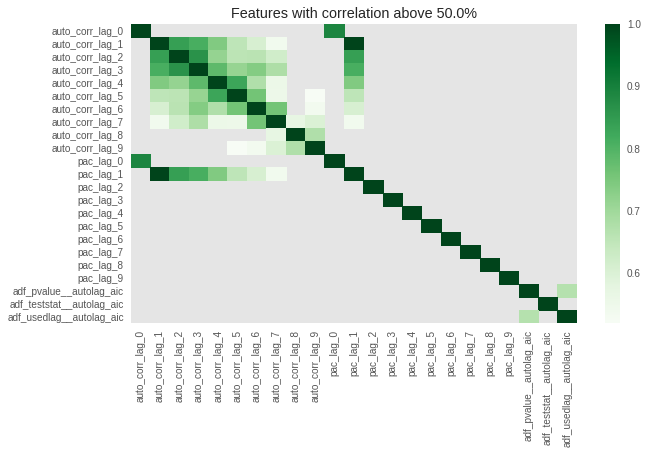

In [176]:
plot_correlated_features(stationary_features_df,0.5)

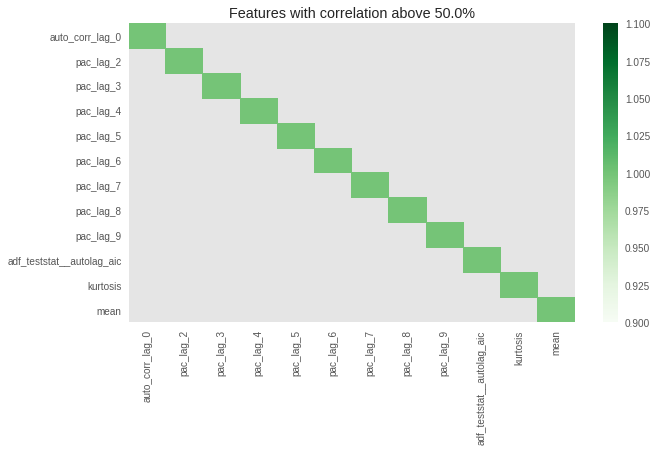

In [177]:
# Drop correlated features (threshold: 0.5)
stationarity_uncorrelated = remove_features_df(stationary_features_df,drop_correlated_pairs(stationary_features_df,0.5))
# Add statistical features to dataframe
stats_features_df = remove_outliers_iqr(features_filtered[filter_features(features_filtered,stats)])
features_uncorrelated = pd.merge(stationarity_uncorrelated,stats_features_df,on='id')
# Check if all features are not correlated
plot_correlated_features(features_uncorrelated,0.5)
plt.savefig(f"{PATH}/images/{product_name}_correlation_{experiment}")

In [178]:
#TODO: https://stats.stackexchange.com/questions/427327/simple-outlier-detection-for-time-series
# random.seed(20)
random_countries = sample(list(features_uncorrelated.index),5)
# product_excl_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
# product_by_countries = features_uncorrelated[features_uncorrelated.index.isin(random_countries)]
features_uncorrelated = scale_features(features_uncorrelated)
X_scaled_transposed = np.asarray(features_uncorrelated)

# Clustering TSFRESH extracted features

## PCA + k-Means

### PCA

Text(0, 0.5, 'PCA 2')

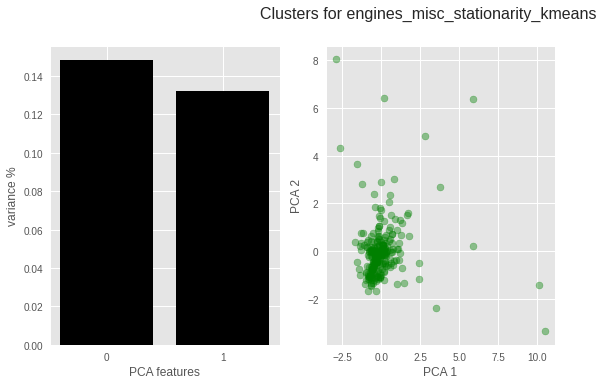

In [179]:
# Standardize the data to have a mean of ~0 and a variance of 1

# TODO: PCA plots and evaluation
# Create a PCA instance: pca
# def calculate_pca():
  # return pca_components_df

# def plot_pca_evaluation():
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_uncorrelated)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)
# Plot the explained variances
features = range(pca.n_components_)


fig = plt.figure(figsize=(14,5.5))
fig.suptitle(f"Clusters for {product_name}_{experiment}_kmeans", fontsize=16)
fig.add_subplot(131)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

fig.add_subplot(132)
plt.scatter(PCA_components[0], PCA_components[1], alpha=.4, color='green')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

### Optimum clusters

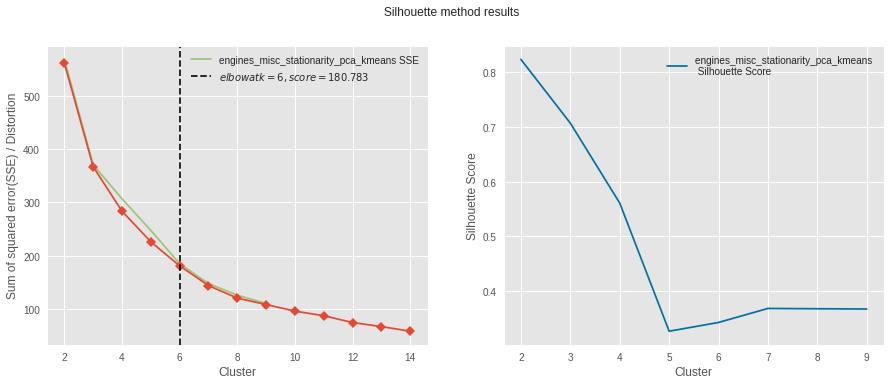

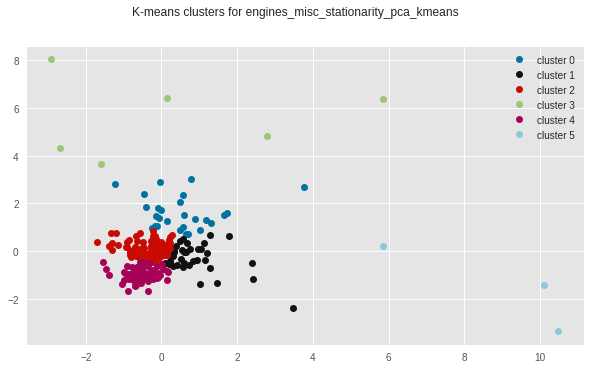

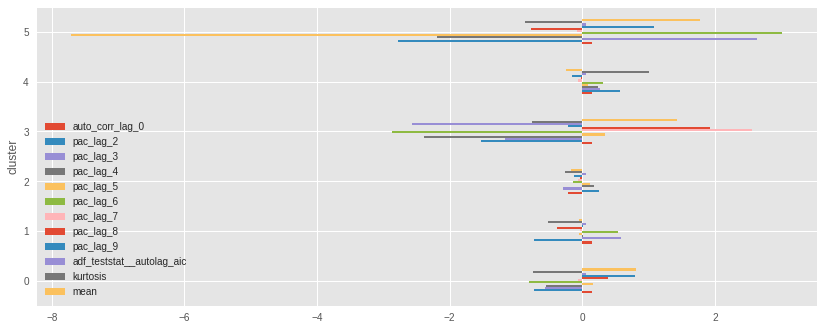

In [180]:
pca_k_value = plot_elbow_silhoutte_k_evaluation(f"{product_name}_{experiment}_pca_kmeans",np.asarray(PCA_components),10)

clusters_features_uncorrelated = plot_kmeans_clusters(np.asarray(PCA_components),pca_k_value,f"{product_name}_{experiment}_pca_kmeans",f"{PATH}/images")

details = [(name,cluster) for name, cluster in zip(features_uncorrelated.index,clusters_features_uncorrelated)]
cluster_df = pd.DataFrame(details,columns=['names','cluster'])
cluster_df['names'].astype('category')
get_names = features_uncorrelated.reset_index().rename(columns={'id':'names'})
get_names.names.astype('category')
country_cluster = pd.merge(get_names,cluster_df,how='inner', on='names')
groups = country_cluster.groupby(['cluster']).agg('mean')

ax = groups.plot(figsize=(14,5.5),kind='barh')
fig = ax.get_figure()
fig.savefig(f"{PATH}/images/{product_name}_{experiment}_pca_kmeans_features.png")